In [35]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import pandas as pd
from tqdm import tqdm

In [114]:
from pymle.models import CIR
from pymle.models import OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [37]:
def Wiener_proc(N, T):
    W = np.zeros(N)  
    delta = T / N
    sqrt_delta = np.sqrt(delta)    
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

# For the Euler-Maruyama approximation
# Geometric Brownian Motion process
def GBM(S, mu, sigma, dt, dW):
    dS = mu * S * dt + sigma * S * dW
    return dS

# Ornstein-Uhlenbeck process
def OU(S, kappa, theta, sigma, dt, dW):
    # kappa = theta1, theta = theta2, sigma = theta3
    dS = (kappa - theta * S) * dt + sigma * dW
    return dS

# Cox-Ingersoll-Ross process #theta 3 params
def CIR(S, kappa, theta, sigma, dt, dW):
    dS = (kappa - theta * S) * dt + sigma * np.sqrt(S) * dW
    return dS

# Auxiliary functions:
def Density_bins_np(A, bins):
    A.sort()
    min_A, max_A = A[0], A[len(A) - 1]
    interval, step = np.linspace(min_A, max_A, bins, retstep=True)
    j = 0
    hist = []
    for i in interval:
        c = 0
        for k in range(j, len(A)):
            if ((A[k] > i) and (A[k] < (i+step))):
                c += 1
        j =+ c
        hist.append([i+step/2, c])
    hist = np.array(hist)
    hist = hist.reshape(-1).reshape(bins, 2)
    return hist

# Calculate the maximum of likelyhood function
def Find_beta(X):
    n = len(X)
    
    # beta 1
    s1 = sum([X[i]*X[i-1] for i in range(1,n)])/n - sum([X[i] for i in range(1,n)])*sum([X[i-1] for i in range(1,n)])/(n**2)
    s2 = sum([X[i-1]**2 for i in range(1,n)])/n - (sum([X[i-1] for i in range(1,n)])**2)/(n**2)
    beta_1 = s1/s2
    
    # beta 2
    beta_2 = (sum([X[i] - beta_1 * X[i-1] for i in range(1, n)]) / n) / (1 - beta_1)
    
    # beta 3
    beta_3 = sum([(X[i] - beta_1 * X[i-1] - beta_2 * (1 - beta_1))**2 for i in range(1, n)]) / n
    
    theta = -np.log(beta_1)
    kappa = theta * beta_2
    sigma = np.sqrt(2 * theta * beta_3 / (1 - beta_1**2))
    #return kappa, theta, sigma
    return [beta_1, beta_2, beta_3]

In [117]:
# Likelyhood optimazator:
def Euler_likelyhood(X, X0, v_theta, dt):
    drift = v_theta[0] + v_theta[1] * X0
    return (X - X0) * drift - dt * (drift**2) / 2

def Eu_like_optim(X, v_theta, dt):
    n = len(X)
    return -sum([Euler_likelyhood(X[i],X[i-1], v_theta, dt) for i in range(1,n)])

def Grad_descent(X, v_theta, dt, N): # fi = fi-1 - grad(fi-1)
    eps = 0.01
    n_theta = v_theta
    args = [v_theta[0], v_theta[1]]
    print("Init =", n_theta)
    for i in range(1,N):
        #print(Eu_like_optim(X, [n_theta[0], n_theta[1]+eps], dt), Eu_like_optim(X, n_theta, dt))
        de_dkap = (Eu_like_optim(X, [n_theta[0]+eps, n_theta[1]], dt) - Eu_like_optim(X, n_theta, dt)) / eps
        de_dthe = (Eu_like_optim(X, [n_theta[0], n_theta[1]+eps], dt) - Eu_like_optim(X, n_theta, dt)) / eps
        #print(de_dkap*eps, de_dthe*eps**2)
        #n_theta[0] = n_theta[0] - de_dkap*eps
        #n_theta[1] = n_theta[1] - de_dthe*eps**2
        if (abs(de_dkap*eps) > 0.001):
            args[0] = args[0] - de_dkap*eps
        if (abs(de_dthe*eps) > 0.001):
            args[1] = args[1] - de_dthe*eps
    return args

In [38]:
# Calculate the maximum of likelyhood function
def Find_beta(X):
    n = len(X)
    
    # beta 1
    s1 = sum([X[i]*X[i-1] for i in range(1,n)])/n - sum([X[i] for i in range(1,n)])*sum([X[i-1] for i in range(1,n)])/(n**2)
    s2 = sum([X[i-1]**2 for i in range(1,n)])/n - (sum([X[i-1] for i in range(1,n)])**2)/(n**2)
    beta_1 = s1/s2
    
    # beta 2
    beta_2 = (sum([X[i] - beta_1 * X[i-1] for i in range(1, n)]) / n) / (1 - beta_1)
    
    # beta 3
    beta_3 = sum([(X[i] - beta_1 * X[i-1] - beta_2 * (1 - beta_1))**2 for i in range(1, n)]) / n
    
    return [beta_1, beta_2, beta_3]

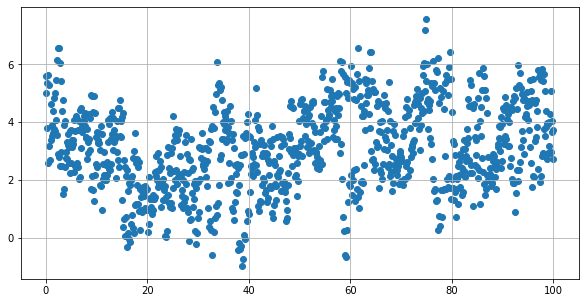

In [5]:
# Task 1:
# Generate OU process with params = (kappa=3,theta=1,sigma=2)
# using the conditional density and then the max.likelyhood estimation

# Data:
N = 1000
T = 100
time_line, dt = np.linspace(0, T, N, retstep=True)
theta = 1
kappa = 3
sigma = 2
k = theta
alpha = kappa / theta
W = Wiener_proc(N, T)
OU_p = np.zeros(N)
OU_p[0] = 3

cond_proba  = np.zeros(N)
expectation = np.zeros(N)
expectation[0], cond_proba[0] = 5, 5
variance    = (sigma**2) * (1 - np.exp(-2*k*dt)) / 2 / k

for i in range(1,N):
    expectation[i] = cond_proba[i-1] * np.exp(-k*dt) + alpha * (1 - np.exp(-k*dt)) 
    cond_proba[i] = rnd.normal(expectation[i-1], np.sqrt(variance))

# Plot figure
plt.figure ( figsize =(10, 5) )
plt.grid ()
plt.scatter(time_line, cond_proba, label="GBM")
plt.show()

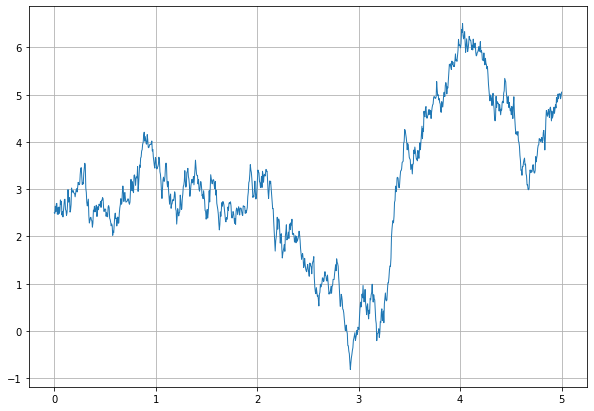

In [6]:
# Task 1:
# Generate OU process with params = (kappa=3,theta=1,sigma=2)
# then evaluate the conditional density and the max.likelyhood estimation

# Data:
N = 1000
T = 5
time_line, dt = np.linspace(0, T, N, retstep=True)
kappa = 3
theta = 1
mu    = 0.3
sigma = 2
alpha = kappa / theta

W = Wiener_proc(N, T)
OU_p = np.zeros(N)
OU_p[0] = 2.5

for i in range(1, N):
    dW = W[i] - W[i-1]
    OU_p[i] = OU_p[i-1] + OU(OU_p[i-1], kappa, theta, sigma, dt, dW)

# Plot figure
plt.figure ( figsize =(10, 7) )
plt.grid ()
# Basic paths (Euler)
plt.plot (time_line, OU_p, linewidth =1.0, label="GBM")
plt.show()

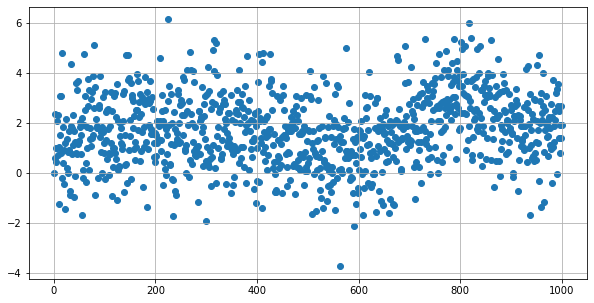

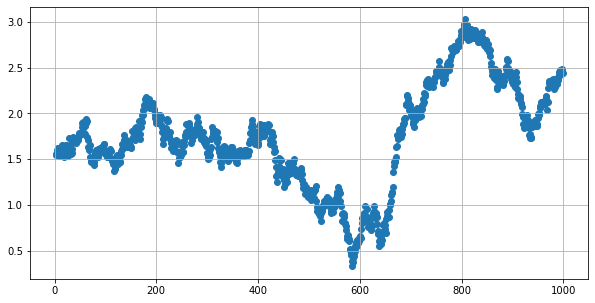

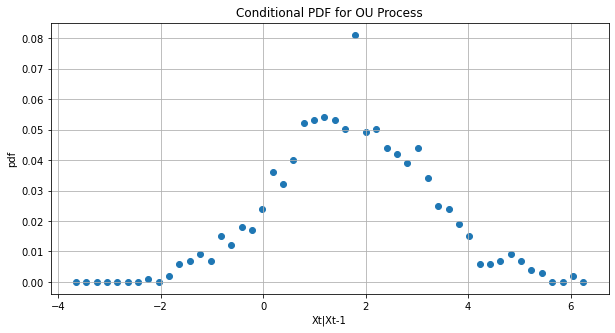

In [7]:
# Evaluate conditional distribution
# Create sample of conditional probabilities:
# alpha = kappa / theta , k = theta

delta = 1
cond_proba  = np.zeros(N-1)
expectation = np.zeros(N-1)
variance    = (sigma**2) * (1 - np.exp(-2*theta)) / 2 / theta
for i in range(1,N-1):
    expectation[i] = OU_p[i-1] * np.exp(-theta) + theta * (1 - np.exp(-theta)) 
    cond_proba[i] = rnd.normal(expectation[i], np.sqrt(variance))
                               
# Plot figure
plt.figure ( figsize =(10, 5) )
plt.grid ()
plt.scatter([i for i in range(1, N)], cond_proba, label="GBM")
plt.show()

plt.figure ( figsize =(10, 5) )
plt.grid ()
plt.scatter([i for i in range(2, N)], expectation[1:], label="GBM")
plt.show()

bins = 50
hist = Density_bins_np(cond_proba, bins)
#print(hist)

# Plot figure
plt.figure ( figsize =(10, 5) )
plt.grid ()
plt.scatter(hist[:,0], hist[:,1]/len(cond_proba))
plt.title ("Conditional PDF for OU Process")
plt.xlabel ("Xt|Xt-1")
plt.ylabel ("pdf")
plt.show()

In [29]:
# Task 1: calculate the max likelyhood
# kappa = k * alpha = 3, alpha = 3
# theta = k = 1
# sigma = 2
N = 100
T = 2


kappa = 3
theta = 1
sigma = 2
alpha = kappa / theta
dt = T / N

W = Wiener_proc(N, T)
OU_p = np.zeros(N)
OU_p[0] = kappa

for i in range(1, N):
    dW = W[i] - W[i-1]
    OU_p[i] = OU_p[i-1] + OU(OU_p[i-1], kappa, theta, sigma, dt, dW)


betas = Find_beta(OU_p)
k = -np.log(betas[0]) / dt
sig = np.sqrt(2 * k * betas[2] / (1 - betas[0]**2))

print("kappa = {:.3f}, theta = {:.3f}, sigma = {:.3f}".format(kappa, theta, sigma))
print(k, betas[1], betas[2])
print("kappa_est = {:.3f}, theta_est = {:.3f}, sigma_est = {:.3f}".format(k*betas[1], betas[1], sig))

kappa = 3.000, theta = 1.000, sigma = 2.000
6.87480094272523 3.2704004738374497 0.07939290325188257
kappa_est = 22.483, theta_est = 3.270, sigma_est = 2.131


In [33]:
# Task 1: calculate the max likelyhood
# kappa = k * alpha = 3, alpha = 3
# theta = k = 1
# sigma = 2
N = 1000
T = 100
time_line, dt = np.linspace(0, T, N, retstep=True)

kappa = 3
theta = 1
sigma = 2
alpha = kappa / theta
dt = T / N


K = 100
ksig = 0
kk = 0
t = 0
S0 = 0

for k in range(K):
    W = Wiener_proc(N, T)
    OU_p = np.zeros(N)
    OU_p[0] = rnd.normal(10, 3)
    #theta = rnd.uniform(0.5, 5)
    for i in range(1, N):
        dW = W[i] - W[i-1]
        OU_p[i] = OU_p[i-1] + OU(OU_p[i-1], kappa, theta, sigma, dt, dW)

    betas = Find_beta(OU_p)
    k = -np.log(betas[0]) / dt
    sig = np.sqrt(2 * k * betas[2] / (1 - betas[0]**2))
    
    ksig += sig
    kk += k
    t += betas[1]
    S0 = OU_p[0]

print("S0 = {:.3f}, kappa = {:.3f}, theta = {:.3f}, sigma = {:.3f}".format(S0, kappa, theta, sigma))
print("kappa_est = {:.3f}, theta_est = {:.3f}, sigma_est = {:.3f}".format(k*betas[1], betas[1]/kappa, sig))

S0 = 13.819, kappa = 3.000, theta = 1.000, sigma = 2.000
kappa_est = 3.625, theta_est = 1.039, sigma_est = 2.152


In [101]:
# Ornstein-Uhlenbeck process
def OU(S, kappa, alpha, sigma, dt, dW):
    dS = kappa * (alpha - S) * dt + sigma * dW
    return dS

In [ ]:
kappa = 0.2
alpha = 3
sigma = 2

N = 1000
M = 500
betas = [] #np.zeros(M)
for j in tqdm(range(M)):
    W = Wiener_proc(N, T)
    OU_p = np.zeros(N)
    OU_p[0] = 2.5

    for i in range(1, N):
        dW = W[i] - W[i-1]
        OU_p[i] = OU_p[i-1] + OU(OU_p[i-1], kappa, alpha, sigma, dt, dW)
    
    betas.append(Find_beta(OU_p))
#beta_mean = betas.mean()
#print(betas.mean())

In [472]:
#print(betas)
npbetas = np.array(betas)
npbetas = npbetas.reshape(-1)
npbetas = npbetas.reshape(M, 3)
print(npbetas[0].mean())
km = -np.log(npbetas[0].mean()) / d
sigm = 2 * km * npbetas[2].mean() / (1 - npbetas[0].mean()**2)
print(km, npbetas[1].mean(), np.sqrt(sigm))

0.5055026817082149
682.2019354749214 0.3915322315388497 13.488609198736594


In [40]:
# Numerical likelyhood estimator:
def Likelyhood_est(X, delta):
    n = len(X)
    param_1 = sum([X[i-1]*X[i] for i in range(1,n)])/sum([X[i-1]**2 for i in range(1,n)])
    param_1 = -np.log(param_1) / delta
    param_2 = sum([(X[i]-X[i-1]*np.exp(-delta*param_1))**2 for i in range(1,n)])*2*param_1/n/(1-np.exp(-2*delta*param_1))
    return param_1, param_2

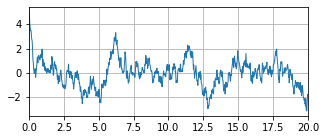

3 2
2.147633605822876 2.0398730320448903


In [41]:
# Task 2:
# Find max likelyhood estimators and compare with expl OU
# kappa = 0, theta = 3, sigma = 2, N = 1000, delta = 1

# Data:
kappa = 0
theta = 3
sigma = 2
N = 1000
T = 20
time_line, dt = np.linspace(0, T, N, retstep=True)

W = Wiener_proc(N, T)
OUp = np.zeros(N)
OUp[0] = 5

for i in range(1, N):
    dW = W[i] - W[i-1]
    OUp[i] = OUp[i-1] + OU(OUp[i-1], kappa, theta, sigma, dt, dW)
# Plot figure
plt.figure ( figsize =(5, 2) )
plt.grid ()
# Basic paths (Euler)
plt.plot (time_line, OUp, linewidth =1.0, label="GBM")
plt.xlim(0, T)
plt.show() 

th, sig = Likelyhood_est(OUp, dt)
print(theta, sigma)
print(th, np.sqrt(sig))

In [120]:
K = 200
N = 1000
T = 2
tth, tsig = 0, 0
OUp[0] = 10
dt = T / N

for k in range(K):
    W = Wiener_proc(N, T)
    OUp = np.zeros(N)
    OUp[0] = 10
    
    for i in range(1, N):
        dW = W[i] - W[i-1]
        OUp[i] = OUp[i-1] + OU(OUp[i-1], kappa, theta, sigma, dt, dW)
    th, sig = Likelyhood_est(OUp, dt)
    tth += th
    tsig += np.sqrt(sig)
    
print("Theta =", theta," Sigma =", sigma)
print("Est theta = {:.3f}, sigma = {:.3f}".format(tth/K, tsig/K))

Theta = 2  Sigma = 0.5
Est theta = 1.393, sigma = 0.505


In [80]:
from pymle.models import IGBM

In [ ]:
# Compare with numerical estimator:

# ===========================
# Set the true model (OU) params, to simulate the process
# ===========================
model = IGBM()  # Cox-Ingersol-Ross 


kappa = 0  # rate of mean reversion
mu = 3  # long term level of process
sigma = 2  # volatility
model.params = np.array([kappa, mu, sigma])

S0 = 5  # initial value of process
T = 5  # num years of the sample
freq = 500  # observations per year
dt = 1. / freq
seed = None

simulator = Simulator1D(S0=S0, M=T * freq, dt=dt, model=model).set_seed(seed=seed)
sample = simulator.sim_path()
param_bounds = [(0, 2), (0, 3), (0.1, 3)]
guess = np.array([1, 2, 1])

kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)
print(f'\nKessler MLE: {kessler_est} \n')

exact_est = AnalyticalMLE(sample, param_bounds, dt, density=ExactDensity(model)).estimate_params(guess)
print(f'\nExact MLE: {exact_est}')

In [72]:
# CKLS model:
def CKLS_m(S, kappa, theta, sigma, gamma, dt, dW):
    return (kappa + theta * S) * dt + sigma * (S**gamma) * dW

import pandas as pd
import numpy as np
from pymle.models.CKLS import CKLS
from pymle.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.TransitionDensity import EulerDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

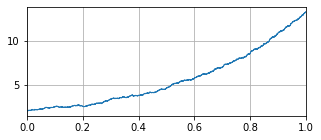

In [73]:
# Task 3:
# Consider CKLS model
# a) generate sample using Euler method
# b) estimate theta, sigma
# c) compute confidence level for all parameters in a fitted SDE

# Data:
N = 10000
T = 1
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls = np.zeros(N)
ckls[0] = 2
kappa, theta, sigma, gamma = 1, 2, 0.5, 0.3

# a)
for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls[i] = ckls[i-1] + CKLS_m(ckls[i-1], kappa, theta, sigma, gamma, dt, dW)
# Plot figure
plt.figure ( figsize =(5, 2) )
plt.grid ()
plt.plot (time_line, ckls, linewidth =1.0, label="Chan-Karolyi-Longstaff-Sanders")
plt.xlim(0, T)
plt.show() 

In [118]:
from pymle.models import CKLS
import numpy as np, scipy.stats as st

In [ ]:
# Task 3: Euler method
model = CKLS() 
kappa, theta, sigma, gamma = 1, 2, 0.5, 0.3
model.params = np.array([kappa, theta, sigma, gamma])

S0 = 20
T = 1
freq = 1000
dt = 1. / freq
seed = None
param_bounds = [(0, 2), (1, 3), (0.1, 1), (0.1, 1)]
guess = np.array([0.5, 1, 0.9, 0.9])

#kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)
#print(f'\nKessler MLE: {kessler_est} \n')

K = 100
eu_params = []

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    S0 = rnd.randint(20, 50)
    simulator = Simulator1D(S0=S0, M=T * freq, dt=dt, model=model).set_seed(seed=seed)
    sample = simulator.sim_path()
    euler_est = AnalyticalMLE(sample, param_bounds, dt, density=EulerDensity(model)).estimate_params(guess).params
    eu_params.append(euler_est)

In [111]:
st.t.interval(0.95, len(eu_params)-1, loc=np.mean(eu_params), scale=st.sem(eu_params))

(array([1.1321575 , 1.24073414, 1.22946349, 1.24035559]),
 array([1.3655519 , 1.25697527, 1.26824591, 1.25735381]))

In [349]:
# Task 4:
# Using Ozaki method for model OU
# a) gen X, dt = 0.01
# b) estimate drift, diffusion
# c) compute conf level 

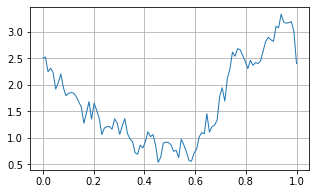

In [113]:
# Data:
N = 100
T = 1
time_line, dt = np.linspace(0, T, N, retstep=True)
kappa = 3
theta = 1
mu    = 0.3
sigma = 2
alpha = kappa / theta

W = Wiener_proc(N, T)
OU_p = np.zeros(N)
OU_p[0] = 2.5

for i in range(1, N):
    dW = W[i] - W[i-1]
    OU_p[i] = OU_p[i-1] + OU(OU_p[i-1], kappa, theta, sigma, dt, dW)

# Plot figure
plt.figure ( figsize =(5, 3) )
plt.grid ()
# Basic paths (Euler)
plt.plot (time_line, OU_p, linewidth =1.0, label="OU")
plt.show()

In [ ]:
# Task 4: Ozaki method
model = OrnsteinUhlenbeck() 
kappa, theta, sigma = 3, 2, 0.5
model.params = np.array([kappa, theta, sigma])

S0 = 5
T = 1
freq = 1000
dt = 1. / freq
seed = None
param_bounds = [(1, 4), (1, 3), (0.1, 1)]
guess = np.array([2, 1, 0.9])

K = 100
ozaki_params = []

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    S0 = rnd.randint(20, 50)
    simulator = Simulator1D(S0=S0, M=T * freq, dt=dt, model=model).set_seed(seed=seed)
    sample = simulator.sim_path()
    ozaki_est = AnalyticalMLE(sample, param_bounds, dt, density=OzakiDensity(model)).estimate_params(guess).params
    ozaki_params.append(ozaki_est)

In [116]:
st.t.interval(0.95, len(ozaki_params)-1, loc=np.mean(ozaki_params), scale=st.sem(ozaki_params))

(array([1.74206505, 1.67202362, 1.75117917]),
 array([1.78523997, 1.8552814 , 1.77612585]))

In [83]:
# Task 5:
# Using Shoji-Ozaki method for model for arbitrary model
# a) gen X, dt = 0.001 with mu = kappa*t, kappa = -2 sigma = 0.2
# b) estimate drift, diffusion
# c) compute conf level 

# Arbitrary model:
def Ar_stoch_model(S, mu, sigma, t, dt, dW):
    dS = mu * t * S * dt + sigma * S * dW
    return dS

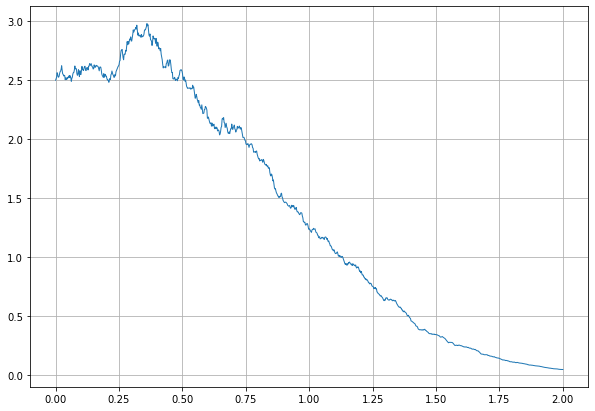

In [84]:
# Data:
N = 1000
T = 2
time_line, dt = np.linspace(0, T, N, retstep=True)
mu    = -2
sigma = 0.2


W = Wiener_proc(N, T)
am = np.zeros(N)
am[0] = 2.5

for i in range(1, N):
    dW = W[i] - W[i-1]
    am[i] = am[i-1] + Ar_stoch_model(am[i-1], mu, sigma, time_line[i], dt, dW)

# Plot figure
plt.figure ( figsize =(10, 7) )
plt.grid ()
# Basic paths (Euler)
plt.plot (time_line, am, linewidth =1.0, label="Arb_model")
plt.show()

In [65]:
# Task 3: Euler method
model = CKLS() 
kappa, theta, sigma, gamma = 1, 2, 0.5, 0.3
model.params = np.array([kappa, theta, sigma, gamma])

S0 = 20
T = 1
freq = 1000
dt = 1. / freq
seed = None
param_bounds = [(0, 2), (1, 3), (0.1, 1), (0.1, 1)]
guess = np.array([0.5, 1, 0.9, 0.9])

#kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)
#print(f'\nKessler MLE: {kessler_est} \n')

K = 100
eu_params = []

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    S0 = rnd.randint(20, 50)
    simulator = Simulator1D(S0=S0, M=T * freq, dt=dt, model=model).set_seed(seed=seed)
    sample = simulator.sim_path()
    euler_est = AnalyticalMLE(sample, param_bounds, dt, density=EulerDensity(model)).estimate_params(guess).params
    eu_params.append(euler_est)

In [57]:
# Task 6:
# Using Kessler method for Hull-White model
# a) gen X, dt = 0.001, So = 2, a(t)=kappa*t, b(t)=mu*sqrt(t), vol=sigma*t
# kappa = 3, mu = 1, sigma = 0.3
# b) estimate drift, diffusion
# c) compute conf level 

# Arbitrary model:
def Hull_White(S, kappa, mu, sigma, t, dt, dW):
    dS = kappa * t * (mu * np.sqrt(t) - S) * dt + sigma * t * S * dW
    return dS

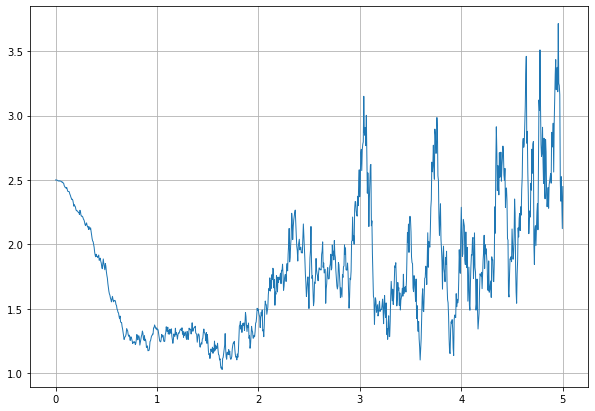

In [58]:
# Data:
N = 1000
T = 5
time_line, dt = np.linspace(0, T, N, retstep=True)
kappa = 3
mu    = 1
sigma = 0.3

W = Wiener_proc(N, T)
hw = np.zeros(N)
hw[0] = 2.5

for i in range(1, N):
    dW = W[i] - W[i-1]
    hw[i] = hw[i-1] + Hull_White(hw[i-1], kappa, mu, sigma, time_line[i], dt, dW)
# Plot figure
plt.figure ( figsize =(10, 7) )
plt.grid ()
# Basic paths (Euler)
plt.plot (time_line, hw, linewidth =1.0, label="Arb_model")
plt.show()